In [1]:
import torch
import torch.optim as optim

In [2]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0] # Celsius
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4] # unknown
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

In [3]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples) # random permutation of ints from 0 to n_samples - 1
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]
train_indices, val_indices

(tensor([2, 9, 0, 6, 1, 3, 4, 5, 7]), tensor([ 8, 10]))

In [4]:
train_t_u = t_u[train_indices].unsqueeze(1)
train_t_c = t_c[train_indices].unsqueeze(1)

val_t_u = t_u[val_indices].unsqueeze(1)
val_t_c = t_c[val_indices].unsqueeze(1)

train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

## Artificial Neural Networks
Note: saturated when changes in input result in little/no changes to output.

PyTorch has building blocks called modules. A PyTorch module is a class derived from nn.Module and can have one or more Parameter instances as attributes, which are tensors whose value is optimized during the training process.

In [5]:
import torch.nn as nn

# Linear is a subclass of nn.Module, which means it has a __call__ method defined. Use it.
linear_model = nn.Linear(1, 1) # args are input size, output size, bias(=True default)
linear_model(val_t_un.unsqueeze(1))

tensor([[[-4.9563]],

        [[-6.9069]]], grad_fn=<AddBackward0>)

In [6]:
linear_model.weight

Parameter containing:
tensor([[-0.9753]], requires_grad=True)

In [7]:
linear_model.bias

Parameter containing:
tensor([-0.2360], requires_grad=True)

In [8]:
x = torch.ones(1)
linear_model(x)

tensor([-1.2112], grad_fn=<AddBackward0>)

Any module in ```nn``` written to produce output for a batch of multiple inputs. The first dimension of the input is the batch dim.

Need tensor of size B x Nin where B is size of batch and Nin is number of inputs. For example, for 10 samples need 10 x 1 input.

Output is tensor of size B x Nout.

In [9]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[-1.2112],
        [-1.2112],
        [-1.2112],
        [-1.2112],
        [-1.2112],
        [-1.2112],
        [-1.2112],
        [-1.2112],
        [-1.2112],
        [-1.2112]], grad_fn=<AddmmBackward0>)

Change prev input to be of desired input form B x Nin.

In [10]:
t_c = t_c.unsqueeze(1)
t_u = t_u.unsqueeze(1)
t_c.shape, t_u.shape

(torch.Size([11, 1]), torch.Size([11, 1]))

Now fit model.

In [11]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

In [12]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[-0.4801]], requires_grad=True),
 Parameter containing:
 tensor([-0.6367], requires_grad=True)]

Now create training loop with model passed in instead of individual params. Also use loss functions from ```torch.nn``` directly, which are subclasses of ```nn.Module``` so need to be created as an instance.

In [41]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val, print_vals=True):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        train_loss = loss_fn(t_p_train, t_c_train)
        
        t_p_val = model(t_u_val)
        val_loss = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        if print_vals:
            if (epoch == 1 or epoch % 1000 == 0) and (epoch != n_epochs):
                print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                      f" Validation loss {val_loss.item():.4f}")
    print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
              f" Validation loss {val_loss.item():.4f}")

In [14]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(3000, optimizer, linear_model, nn.MSELoss(), train_t_un, val_t_un, train_t_c, val_t_c)

print(linear_model.weight, linear_model.bias)

Epoch 1, Training loss 310.1073, Validation loss 416.4771
Epoch 1000, Training loss 2.9976, Validation loss 7.4397
Epoch 2000, Training loss 2.4491, Validation loss 5.7089
Epoch 3000, Training loss 2.4376, Validation loss 5.4824
Parameter containing:
tensor([[5.2247]], requires_grad=True) Parameter containing:
tensor([-16.4597], requires_grad=True)


Extending model to have one hidden layer.

In [15]:
seq_model = nn.Sequential(nn.Linear(1, 13), 
                          nn.Tanh(), 
                          nn.Linear(13, 1))
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [17]:
[param.shape for param in seq_model.parameters()] # weight and bias from both first and second linear modules

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [18]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


Can also explicitly name layers.

In [19]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([('hidden_linear', nn.Linear(1, 8)),
                                       ('hidden_activation', nn.Tanh()),
                                       ('output_linear', nn.Linear(8, 1))
                                      ]))
seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [20]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [23]:
seq_model.output_linear.weight 

Parameter containing:
tensor([[ 0.1219, -0.0828,  0.2277,  0.0074, -0.1700,  0.2736,  0.3079, -0.1365]],
       requires_grad=True)

In [24]:
seq_model.output_linear.bias

Parameter containing:
tensor([-0.0998], requires_grad=True)

Run training loop with sequential model.

In [27]:
optimizer = optim.SGD(seq_model.parameters(), 1e-3)

training_loop(5000, optimizer, seq_model, nn.MSELoss(), train_t_un, val_t_un, train_t_c, val_t_c)

print('output', seq_model(val_t_un))
print('answer', val_t_c)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 4.1099, Validation loss 10.6521
Epoch 1000, Training loss 3.5550, Validation loss 8.6022
Epoch 2000, Training loss 3.3147, Validation loss 7.4831
Epoch 3000, Training loss 3.1881, Validation loss 6.8195
Epoch 4000, Training loss 3.1079, Validation loss 6.3686
Epoch 5000, Training loss 3.0483, Validation loss 6.0199
output tensor([[ 9.2495],
        [22.2165]], grad_fn=<AddmmBackward0>)
answer tensor([[ 6.],
        [21.]])
hidden tensor([[ 1.1032e-05],
        [-3.7549e-02],
        [ 4.5048e-03],
        [ 1.6936e-04],
        [ 1.2288e-06],
        [ 3.2008e-04],
        [-2.3273e-05],
        [ 9.0582e-03]])


Compare with linear model.

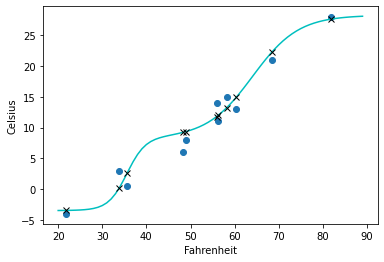

In [30]:
from matplotlib import pyplot as plt

t_range = torch.arange(20, 90).unsqueeze(1)
fig, ax = plt.subplots()
ax.set(xlabel="Fahrenheit", ylabel="Celsius")
ax.plot(t_u.numpy(), t_c.numpy(), 'o') # correct labels
ax.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-') # whole curve (behavior between samples)
ax.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx') # fitted values

## Exercises
**1. Changing number of hidden neurons and learning rate.**

In [55]:
def run_model(n_neurons, learning_rate=1e-3, print_vals=False, print_weights=False):
    seq_model = nn.Sequential(nn.Linear(1, n_neurons), 
                              nn.Tanh(), 
                              nn.Linear(n_neurons, 1))

    optimizer = optim.SGD(seq_model.parameters(), learning_rate)

    training_loop(5000, optimizer, seq_model, nn.MSELoss(), train_t_un, val_t_un, train_t_c, val_t_c, print_vals)
    
    print('output', seq_model(val_t_un))
    if print_weights:        
        print('answer', val_t_c)
        print('hidden', seq_model[2].weight.grad)

In [54]:
for n in range(1, 11):
    print(f'\n{n} neurons in hidden layer:\n')
    run_model(n)


1 neurons in hidden layer:

Epoch 5000, Training loss 10.0914, Validation loss 1.8650
output tensor([[ 6.1014],
        [19.0175]], grad_fn=<AddmmBackward0>)

2 neurons in hidden layer:

Epoch 5000, Training loss 2.3857, Validation loss 2.4569
output tensor([[ 7.8936],
        [20.8368]], grad_fn=<AddmmBackward0>)

3 neurons in hidden layer:

Epoch 5000, Training loss 2.0353, Validation loss 1.9894
output tensor([[ 7.9727],
        [20.7040]], grad_fn=<AddmmBackward0>)

4 neurons in hidden layer:

Epoch 5000, Training loss 2.0147, Validation loss 1.5253
output tensor([[ 7.7362],
        [20.8093]], grad_fn=<AddmmBackward0>)

5 neurons in hidden layer:

Epoch 5000, Training loss 1.9676, Validation loss 1.6000
output tensor([[ 7.7601],
        [20.6800]], grad_fn=<AddmmBackward0>)

6 neurons in hidden layer:

Epoch 5000, Training loss 1.9258, Validation loss 1.8986
output tensor([[ 7.9039],
        [20.5842]], grad_fn=<AddmmBackward0>)

7 neurons in hidden layer:

Epoch 5000, Training l

In [52]:
for n in range(10, 110, 10):
    print(f'\n{n} neurons in hidden layer:\n')
    run_model(n)


10 neurons in hidden layer:

Epoch 5000, Training loss 1.9013, Validation loss 2.2206
output tensor([[ 7.9991],
        [20.3329]], grad_fn=<AddmmBackward0>)

20 neurons in hidden layer:

Epoch 5000, Training loss 1.9983, Validation loss 2.5862
output tensor([[ 8.2691],
        [20.4212]], grad_fn=<AddmmBackward0>)

30 neurons in hidden layer:

Epoch 5000, Training loss 1.9625, Validation loss 2.9274
output tensor([[ 7.7849],
        [19.4174]], grad_fn=<AddmmBackward0>)

40 neurons in hidden layer:

Epoch 5000, Training loss 1.8491, Validation loss 2.8336
output tensor([[ 8.0515],
        [19.7934]], grad_fn=<AddmmBackward0>)

50 neurons in hidden layer:

Epoch 5000, Training loss 2.0364, Validation loss 3.3962
output tensor([[ 7.7974],
        [19.1674]], grad_fn=<AddmmBackward0>)

60 neurons in hidden layer:

Epoch 5000, Training loss 1.8564, Validation loss 3.1094
output tensor([[ 8.1321],
        [19.7067]], grad_fn=<AddmmBackward0>)

70 neurons in hidden layer:

Epoch 5000, Trai

So, in this case increasing the number of hidden neurons increases validation loss in general. Now change the learning rate.

In [63]:
for lr in [0.1**i for i in range(1, 11)]:
    print(f'\nLearning Rate: {lr}')
    run_model(13, lr)


Learning Rate: 0.1
Epoch 5000, Training loss nan, Validation loss nan
output tensor([[nan],
        [nan]], grad_fn=<AddmmBackward0>)

Learning Rate: 0.010000000000000002
Epoch 5000, Training loss 1.4629, Validation loss 8.3590
output tensor([[ 8.1255],
        [17.8401]], grad_fn=<AddmmBackward0>)

Learning Rate: 0.0010000000000000002
Epoch 5000, Training loss 1.8595, Validation loss 2.4561
output tensor([[ 8.0162],
        [20.0795]], grad_fn=<AddmmBackward0>)

Learning Rate: 0.00010000000000000002
Epoch 5000, Training loss 13.4294, Validation loss 17.2636
output tensor([[ 9.3713],
        [16.1887]], grad_fn=<AddmmBackward0>)

Learning Rate: 1.0000000000000003e-05
Epoch 5000, Training loss 78.2484, Validation loss 91.7353
output tensor([[7.2144],
        [7.5102]], grad_fn=<AddmmBackward0>)

Learning Rate: 1.0000000000000004e-06
Epoch 5000, Training loss 170.8897, Validation loss 231.6279
output tensor([[0.2423],
        [0.2614]], grad_fn=<AddmmBackward0>)

Learning Rate: 1.000000

Validation loss is generally increasing as the learning rate decreases (past a certain point). Let's try learning rates around 1e-3, which seems to work best.

In [77]:
for lr in [1e-3*i for i in range(1, 10)]:
    print(f'\nLearning Rate: {lr}')
    run_model(13, lr)


Learning Rate: 0.001
Epoch 5000, Training loss 1.8702, Validation loss 2.5303
output tensor([[ 8.0367],
        [20.0447]], grad_fn=<AddmmBackward0>)

Learning Rate: 0.002
Epoch 5000, Training loss 1.8598, Validation loss 3.0534
output tensor([[ 8.3240],
        [20.1154]], grad_fn=<AddmmBackward0>)

Learning Rate: 0.003
Epoch 5000, Training loss 1.8531, Validation loss 4.4645
output tensor([[ 8.0806],
        [18.8226]], grad_fn=<AddmmBackward0>)

Learning Rate: 0.004
Epoch 5000, Training loss 1.8412, Validation loss 4.6165
output tensor([[ 8.0424],
        [18.5552]], grad_fn=<AddmmBackward0>)

Learning Rate: 0.005
Epoch 5000, Training loss 1.8509, Validation loss 4.1345
output tensor([[ 7.7810],
        [18.5680]], grad_fn=<AddmmBackward0>)

Learning Rate: 0.006
Epoch 5000, Training loss 1.7305, Validation loss 4.7539
output tensor([[ 7.8901],
        [18.2598]], grad_fn=<AddmmBackward0>)

Learning Rate: 0.007
Epoch 5000, Training loss 1.7572, Validation loss 5.7353
output tensor([

In [78]:
for lr in [1e-4*i for i in range(1, 10)]:
    print(f'\nLearning Rate: {lr}')
    run_model(13, lr)


Learning Rate: 0.0001
Epoch 5000, Training loss 10.9058, Validation loss 13.0131
output tensor([[ 9.1022],
        [16.9512]], grad_fn=<AddmmBackward0>)

Learning Rate: 0.0002
Epoch 5000, Training loss 4.7291, Validation loss 3.5992
output tensor([[ 8.0446],
        [19.2638]], grad_fn=<AddmmBackward0>)

Learning Rate: 0.00030000000000000003
Epoch 5000, Training loss 3.2471, Validation loss 4.2588
output tensor([[ 8.4801],
        [19.4621]], grad_fn=<AddmmBackward0>)

Learning Rate: 0.0004
Epoch 5000, Training loss 2.4046, Validation loss 2.6131
output tensor([[ 8.0476],
        [19.9837]], grad_fn=<AddmmBackward0>)

Learning Rate: 0.0005
Epoch 5000, Training loss 2.1379, Validation loss 2.1915
output tensor([[ 7.9133],
        [20.1504]], grad_fn=<AddmmBackward0>)

Learning Rate: 0.0006000000000000001
Epoch 5000, Training loss 2.0220, Validation loss 2.4350
output tensor([[ 8.0090],
        [20.0870]], grad_fn=<AddmmBackward0>)

Learning Rate: 0.0007
Epoch 5000, Training loss 1.9636

So, it appears the best learning rate according to validation loss is around 0.0008.

**2. Create new model for wine data. Copying normalization from Ch.4 notebook**

In [81]:
import pandas as pd
import numpy as np

In [82]:
wineq_pd = pd.read_csv('data/p1ch4/tabular-wine/winequality-white.csv', sep=';')
wineq = torch.from_numpy(wineq_pd.to_numpy(dtype=np.float32))

In [83]:
wineq.shape, wineq.dtype

(torch.Size([4898, 12]), torch.float32)

Now have a floating point tensor with all the columns including the last, which refers to the quality score.

In [84]:
data = wineq[:, :-1] # excluding score
data, data.shape

(tensor([[ 7.0000,  0.2700,  0.3600,  ...,  3.0000,  0.4500,  8.8000],
         [ 6.3000,  0.3000,  0.3400,  ...,  3.3000,  0.4900,  9.5000],
         [ 8.1000,  0.2800,  0.4000,  ...,  3.2600,  0.4400, 10.1000],
         ...,
         [ 6.5000,  0.2400,  0.1900,  ...,  2.9900,  0.4600,  9.4000],
         [ 5.5000,  0.2900,  0.3000,  ...,  3.3400,  0.3800, 12.8000],
         [ 6.0000,  0.2100,  0.3800,  ...,  3.2600,  0.3200, 11.8000]]),
 torch.Size([4898, 11]))

In [85]:
target = wineq[:, -1]
target, target.shape

(tensor([6., 6., 6.,  ..., 6., 7., 6.]), torch.Size([4898]))

One-hot encoding

In [86]:
target

tensor([6., 6., 6.,  ..., 6., 7., 6.])

In [87]:
target_onehot = torch.zeros(target.shape[0], 10)
target_onehot.scatter_(1, target.unsqueeze(1).long(), 1.0) # for each row take idx corresp to element in target and set to 1.0 in target_onehot
# first arg is dim along which the following two args are specified, 
# second arg is a column tensor indicating idx of element to scatter,
# third arg is the elements/single scalar to scatter

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

More data prep

In [88]:
data_mean = torch.mean(data, dim=0)
data_mean # gets mean in every column

tensor([6.8548e+00, 2.7824e-01, 3.3419e-01, 6.3914e+00, 4.5772e-02, 3.5308e+01,
        1.3836e+02, 9.9403e-01, 3.1883e+00, 4.8985e-01, 1.0514e+01])

In [89]:
data_var = torch.var(data, dim=0)
data_var

tensor([7.1211e-01, 1.0160e-02, 1.4646e-02, 2.5726e+01, 4.7733e-04, 2.8924e+02,
        1.8061e+03, 8.9455e-06, 2.2801e-02, 1.3025e-02, 1.5144e+00])

In [90]:
data_normalized = (data - data_mean)/torch.sqrt(data_var)

Now back to new analysis. Use normalized data and one-hot encoding of target.

In [97]:
data_normalized.shape, target_onehot.shape

(torch.Size([4898, 11]), torch.Size([4898, 10]))

In [98]:
n_inputs = data_normalized.shape[1]
n_outputs = target_onehot.shape[1]
n_hidden_neurons = 10
seq_model = nn.Sequential(nn.Linear(n_inputs, n_hidden_neurons),
                          nn.Tanh(),
                          nn.Linear(n_hidden_neurons, n_outputs))

Create training and validation data.

In [ ]:
train_set, val_set = torch.utils.random_split()